#Projeto 5: Detecção de Transações Fraudulentas

### Bibliotecas

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

### Importação e análise

In [2]:
df = pd.read_csv("fraudes.csv")
df.head()

,transaction_id,customer_id,amount,time,location,is_fraud
0,TRANS_1668,CUST_257,3871.09,10,Loja Física,0
1,TRANS_731,CUST_391,4222.56,23,Online,1
2,TRANS_1644,CUST_360,4451.62,20,Online,0
3,TRANS_499,CUST_342,2698.11,4,Online,0
4,TRANS_827,CUST_146,2305.39,2,Online,0


In [6]:
#Quantidade de registros

print(f'A quantidade de registros no dataset é de: {df.shape[0]}')

A quantidade de registros no dataset é de: 3784


In [5]:
#Quantidade de atributos

print(f'A quantidade de atributos no dataset é de: {df.shape[1]}')

A quantidade de atributos no dataset é de: 6


#Valores ausentes

In [7]:
#Verificando valores ausentes.

df.isnull().sum()

,0
transaction_id,0
customer_id,0
amount,0
time,0
location,0
is_fraud,0


### Pré-Processamento

In [8]:
# Remove colunas sem valor semântico
df = df.drop(columns=['transaction_id', 'customer_id'])


# Pré-processa Variáveis Categóricas
df_encoded = pd.get_dummies(df, columns=['location'], drop_first=True)

# Separa
X = df_encoded.drop(columns=['is_fraud'])
y = df_encoded['is_fraud']

# Normaliza
scaler = StandardScaler()
X[['amount', 'time']] = scaler.fit_transform(X[['amount', 'time']])

# Divide entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train)

        amount      time  location_Online
1094 -1.032058  0.774219            False
108   0.414379 -0.730548            False
1684 -1.134727  0.637422             True
3648 -1.684119 -0.046563             True
2284  1.186531  0.774219             True
...        ...       ...              ...
1130  0.632095  1.047814             True
1294  1.434481 -0.730548             True
860  -0.679811 -1.414534             True
3507 -0.139940 -1.824925             True
3174 -1.742373  1.047814             True

[3027 rows x 3 columns]


#Rede Neural MLP com Tunagem de Hiperparâmetros

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Melhores hiperparâmetros: {'activation': 'tanh', 'alpha': np.float64(0.00025081156860452336), 'batch_size': 128, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'learning_rate_init': np.float64(0.0005645041271999773), 'solver': 'adam'}

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84       363
           1       0.84      0.90      0.87       394

    accuracy                           0.85       757
   macro avg       0.86      0.85      0.85       757
weighted avg       0.86      0.85      0.85       757


Matriz de Confusão:


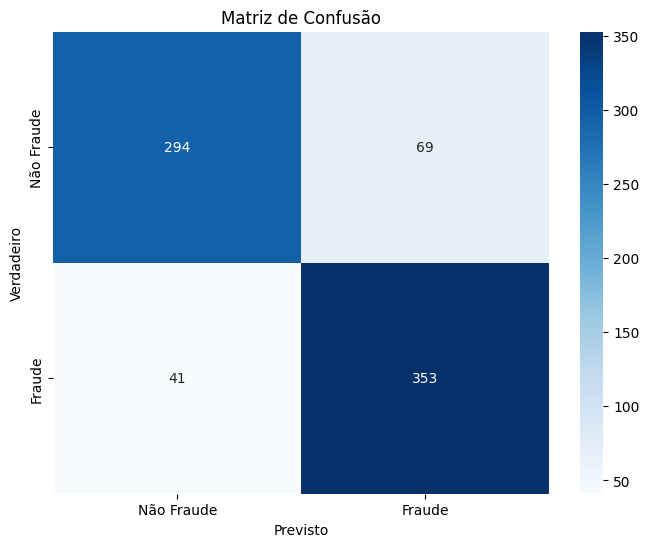

In [9]:
# Define o modelo
mlp = MLPClassifier(max_iter=500, random_state=42)

# Define os hiperparâmetros para tunagem
param_distributions = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],  # Tamanhos das camadas ocultas da rede neural
    'activation': ['relu', 'tanh','sigmoid'],                    # Função de ativação usada nos neurônios
    'solver': ['adam', 'sgd'],                                   # Algoritmo de otimização usado para treinar a rede
    'alpha': reciprocal(1e-4, 1e-2),                              # Parâmetro de regularização L2 (controle de overfitting)
    'learning_rate': ['constant', 'invscaling', 'adaptive'],     # Estratégia de ajuste da taxa de aprendizado
    'learning_rate_init': uniform(0.0001, 0.01),                 # Valor inicial da taxa de aprendizado
    'batch_size': [32, 64, 128]                                  # Tamanho dos lotes usados no treinamento
}

# Configura a busca randomica
random_search = RandomizedSearchCV(mlp, param_distributions, n_iter=10, cv=3, random_state=42, n_jobs=-1)

# Realiza a tunagem dos hiperparâmetros
random_search.fit(X_train, y_train)

# Melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros:", random_search.best_params_)

# Melhor modelo encontrado
best_mlp = random_search.best_estimator_

# Predições no conjunto de teste
y_pred = best_mlp.predict(X_test)

# Avaliação do modelo
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

print("\nMatriz de Confusão:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Não Fraude', 'Fraude'], yticklabels=['Não Fraude', 'Fraude'])
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()


# Impacto Financeiro do Modelo

In [11]:
# Assumindo um valor médio de transação para estimar o custo de falsos positivos e economia
# Você pode ajustar isso com base no seu conhecimento do domínio ou análise de dados
average_transaction_amount = df['amount'].mean()

# Obtém os valores da matriz de confusão
# Verdadeiros Negativos (TN), Falsos Positivos (FP), Falsos Negativos (FN), Verdadeiros Positivos (TP)
tn, fp, fn, tp = cm.ravel()

# Calcula o custo de falsos positivos
# Cada falso positivo é uma transação legítima incorretamente sinalizada como fraude, potencialmente levando a inconvenientes para o cliente e perda de negócios.
# Estimamos este custo multiplicando o número de falsos positivos pelo valor médio da transação.
cost_of_false_positives = fp * average_transaction_amount

# Calcula a economia de fraudes corretamente identificadas (Verdadeiros Positivos)
# Cada verdadeiro positivo é uma transação fraudulenta corretamente identificada, prevenindo perdas financeiras.
# Estimamos esta economia multiplicando o número de verdadeiros positivos pelo valor médio da transação.
savings_from_true_positives = tp * average_transaction_amount

# Calcula o impacto monetário líquido
net_monetary_impact = savings_from_true_positives - cost_of_false_positives

print(f"\nImpacto Econômico do Modelo:")
print(f"Custo de Falsos Positivos: R$ {cost_of_false_positives:,.2f}")
print(f"Economia de Verdadeiros Positivos: R$ {savings_from_true_positives:,.2f}")
print(f"Impacto Monetário Líquido: R$ {net_monetary_impact:,.2f}")


Impacto Econômico do Modelo:
Custo de Falsos Positivos: R$ 180,432.57
Economia de Verdadeiros Positivos: R$ 923,082.56
Impacto Monetário Líquido: R$ 742,649.99
